In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-32o2gg7d
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-32o2gg7d
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101056 sha256=af5a58ae955427ff19b39043662131a39b01b08278c90ee282cc5839acad1a1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-09d_6_vc/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [ ]:
import cv2
import os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import random

from __future__ import print_function, division
import scipy

# from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers import PReLU, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys

import keras.backend as K

from google.colab.patches import cv2_imshow

In [ ]:
# Define function to add noise
def add_noise(image, mean=0, stddev=10):
    """Adds Gaussian noise to an image."""
    noise = np.zeros(image.shape, np.uint8)
    cv2.randn(noise, mean, stddev)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Define function to add blurring
def add_blur(image, kernel_size=3, stddev=10):
    """Adds Gaussian blur to an image."""
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), stddev)
    return blurred_image

# Define function to add compression
def add_compression(image, quality=50):
    """Adds JPEG compression to an image."""
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, compressed_image = cv2.imencode('.jpg', image, encode_param)
    decompressed_image = cv2.imdecode(compressed_image, 1)
    return decompressed_image

# Define function to add distortion
def add_distortion(image, amplitude=5):
    """Adds sinusoidal distortion to an image."""
    rows, cols = image.shape[:2]
    distorted_image = np.zeros(image.shape, dtype=image.dtype)
    for i in range(rows):
        for j in range(cols):
            offset_x = int(amplitude * np.sin(2 * 3.14 * i / 180))
            offset_y = int(amplitude * np.cos(2 * 3.14 * j / 180))
            if i+offset_y < rows and j+offset_x < cols:
                distorted_image[i,j] = image[(i+offset_y)%rows,(j+offset_x)%cols]
    return distorted_image

# Define function to add artifacts
def add_artifacts(image, kernel_size=3, iterations=1):
    """Adds erosion artifacts to an image."""
    artifacts_image = cv2.erode(image, np.ones((kernel_size, kernel_size), np.uint8), iterations=iterations)
    return artifacts_image

def resize_image(img):
    # Get the original dimensions of the image
    height, width = img.shape[:2]
    # set reduction factor to 0.25 or 25% to get image super resolution of 4x
    reduction_factor = 0.25
    # Calculate the new dimensions based on the reduction factor while maintaining aspect ratio
    new_width = int(width * reduction_factor)
    new_height = int(height * reduction_factor)
    new_dim = (new_width, new_height)
    # Resize the image
    resized_img = cv2.resize(img, new_dim, interpolation=cv2.INTER_AREA)
    return resized_img

In [ ]:
class DataLoader():
    def __init__(self, dataset_name, hr_name, lr_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.hr_name = hr_name+"/"
        self.lr_name = lr_name+"/"

    def generate_mixture(self,img):
        # print(img.shape)
        # cv2_imshow(img)
        no_of_aug = np.random.randint(1,5)
        mlist = [1,2,3,4,5]
        # x=np.random.sample(mlist)
        # augs=np.random.random_sample(x,no_of_aug)
        augs = random.sample(mlist, no_of_aug)
        # augs = mlist
        # print(augs)
        # Add random values to each function
        # cv2.imwrite("/content/drive/MyDrive/SEM 6 MINI PROJECT GAN/DATASET/HR/"+str(c)+".jpg",img)
        if [1,5] in augs:
          x = random.choices([1,5])
          augs.remove(x)
        for i in augs:
          if i==1:
            img = add_noise(img, mean=np.random.randint(20, 100), stddev=np.random.randint(20, 60))
            print("noise")
            # cv2_imshow(noise_img)
          elif i==2:
            img = add_blur(img, kernel_size=np.random.choice(range(3, 21, 2)), stddev=np.random.randint(20, 60))
            print("blur")
            # cv2_imshow(blur_img)
            # cv2.imwrite("/content/drive/MyDrive/SEM 6 MINI PROJECT GAN/DATASET/LR/"+str(c)+".jpg",blur_img)
          elif i==3:
            img = add_compression(img, quality=np.random.randint(0, 70))
            print("compress")
            # cv2_imshow(compress_img)
            # cv2.imwrite("/content/drive/MyDrive/SEM 6 MINI PROJECT GAN/DATASET/LR/"+str(c)+".jpg",compress_img)
          elif i==4:
            img = add_distortion(img, amplitude=np.random.randint(5, 50))
            print("distort")
            # cv2_imshow(distort_img)
            # cv2.imwrite("/content/drive/MyDrive/SEM 6 MINI PROJECT GAN/DATASET/LR/"+str(c)+".jpg",distort_img)
          elif i==5:
            img = add_artifacts(img, kernel_size=np.random.choice(range(3, 21, 2)), iterations=np.random.randint(1, 5))
            print("artifact")
            # cv2_imshow(artifacts_img)
            # cv2.imwrite("/content/drive/MyDrive/SEM 6 MINI PROJECT GAN/DATASET/LR/"+str(c)+".jpg",artifacts_img)
          # elif i==6:
          #   resized_img = resize_image(img)
          #   print("resized_img")
          #   cv2_imshow(resized_img)
        print("---------")
        return img

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"

        # Data_Dir = self.dataset_name #show contain hr and lr folder inside
        Data_Dir = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/Data/"
        imgs_in_dir = [f for f in listdir(Data_Dir + self.hr_name) if isfile(join(Data_Dir + self.hr_name, f))]

        batch_images = np.random.choice(imgs_in_dir, size=batch_size)

        imgs_hr = []
        imgs_lr = []
        for img_path in batch_images:
            # print(img_path)
            img_hr = self.imread(Data_Dir+self.hr_name+img_path)
            img_lr = self.generate_mixture(img_hr)
            # print(img_lr)

            imgs_hr.append(img_hr)
            imgs_lr.append(img_lr)

            # print(imgs_hr)

        imgs_hr = np.array(imgs_hr) / 255
        imgs_lr = np.array(imgs_lr) / 255

        return imgs_hr, imgs_lr


    def load_predict_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"

        Data_Dir = self.dataset_name #show contain hr and lr folder inside
        Data_Dir = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/"
        imgs_in_dir = [f for f in listdir(Data_Dir + self.hr_name) if isfile(join(Data_Dir + self.hr_name, f))]

        batch_images = np.random.choice(imgs_in_dir, size=batch_size)

        imgs_lr = []
        for img_path in batch_images:
            # print(img_path)
            img_lr = self.imread(Data_Dir+self.lr_name+img_path)

            imgs_lr.append(img_lr)

            # print(imgs_hr)

        imgs_lr = np.array(imgs_lr) / 255

        return imgs_lr

    def imread(self, path):
      img = cv2.resize(cv2.imread(path), (128,128))
      # cv2_imshow(img)
      img  = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      # import matplotlib.pyplot as plt
      # plt.imshow(img)
      return img

In [ ]:
class SRDCGAN():
  # generator srgan, discriminaor dcgan

    def __init__(self):
        self.psnr = []

        # Input shape
        self.channels = 3
        self.lr_height = 128                 # Low resolution height
        self.lr_width = 128                  # Low resolution width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = self.lr_height   # High resolution height
        self.hr_width = self.lr_width     # High resolution width
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        # Number of residual blocks in the generator
        self.n_residual_blocks = 12

        # The hyper-parameters β1 and β2 of Adam are initial decay rates used when estimating the first and second moments of the gradient, which are multiplied by themselves (exponentially) at the end of each training step (batch).
        # optimizer = Adam(0.0001, 0.9)
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9)

        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Configure data loader
        self.dataset_name = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/Data"
        self.hr_folder_name = ""
        self.lr_folder_name = ""
        self.data_load = DataLoader(dataset_name=self.dataset_name,hr_name=self.hr_folder_name,lr_name=self.lr_folder_name,img_res=(128,128))

        # Calculate output shape of D (PatchGAN)
        patch = int(self.hr_height / 2**3)
        self.disc_patch = (1,1)

        # Number of filters in the first layer of G and D
        self.gf = 256
        self.df = 256

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # High res. and low res. images
        img_hr = Input(shape=self.hr_shape)
        img_lr = Input(shape=self.lr_shape)

        # Generate high res. version from low res.
        fake_hr = self.generator(img_lr)

        # Extract image features of the generated img
        fake_features = self.vgg(fake_hr)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminator determines validity of generated high res. images
        validity = self.discriminator(fake_hr)

        self.combined = Model([img_lr, img_hr], [validity, fake_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-4, 1],
                              optimizer=optimizer,metrics=["accuracy"])


    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        vgg = VGG19(weights="imagenet",include_top=False)
        # Set outputs to outputs of last conv. layer in block 3
        # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        # vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.hr_shape)

        # Extract image features
        img_features = vgg(img)

        return Model(img, img_features)

    def build_generator(self):

        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):

            """Layers used during upsampling"""
            u = Conv2D(256, kernel_size=3, strides=1, padding='same')(layer_input)
            u = UpSampling2D(size=1)(u)
            u = Activation('relu')(u)
            return u

        # Low resolution image input
        img_lr = Input(shape=self.lr_shape)

        modelPath = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/Model/generator.h5"
        if os.path.exists(modelPath):
          print("exists")
          model = load_model(modelPath)
          return model
        else :
          c1 = Conv2D(256, kernel_size=9, strides=1, padding='same')(img_lr)
          # Pre-residual block

          c1 = Activation('relu')(c1)

          # Propogate through residual blocks
          r = residual_block(c1, self.gf)
          for _ in range(self.n_residual_blocks - 1):
              r = residual_block(r, self.gf)

          # Post-residual block
          c2 = Conv2D(256, kernel_size=3, strides=1, padding='same')(r)
          c2 = BatchNormalization(momentum=0.8)(c2)
          c2 = Add()([c2, c1])

          # Upsampling
          u1 = deconv2d(c2)
          u2 = deconv2d(u1)

          # Generate high resolution output
          gen_hr = Conv2D(self.channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

          return Model(img_lr, gen_hr)

    def build_discriminator(self):

      modelPath = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/Model/discriminator.h5"
      if os.path.exists(modelPath):
        print("exists")
        model = load_model(modelPath)
        return model
      else :
        model=Sequential()

        model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=self.hr_shape,padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128,kernel_size=3,strides=2,padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128,kernel_size=3,strides=2,padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128,kernel_size=3,strides=1,padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())

        model.add(Dense(1,activation="sigmoid"))
        model.summary()

        gen_hr=Input(shape=self.hr_shape)
        validation=model(gen_hr)

        return Model(gen_hr,validation)
    # def build_discriminator(self):

    #     def d_block(layer_input, filters, strides=1, bn=True):
    #         """Discriminator layer"""
    #         d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
    #         d = LeakyReLU(alpha=0.2)(d)
    #         if bn:
    #             d = BatchNormalization(momentum=0.8)(d)
    #         return d

    #     # Input img
    #     d0 = Input(shape=self.hr_shape)

    #     d1 = d_block(d0, self.df, bn=False)
    #     d2 = d_block(d1, self.df, strides=2)
    #     d3 = d_block(d2, self.df*2)
    #     d4 = d_block(d3, self.df*2, strides=2)
    #     d5 = d_block(d4, self.df*4)
    #     d6 = d_block(d5, self.df*4, strides=2)
    #     d7 = d_block(d6, self.df*8)
    #     d8 = d_block(d7, self.df*8, strides=2)

    #     d9 = Dense(self.df*16)(d8)
    #     d10 = LeakyReLU(alpha=0.2)(d9)
    #     validity = Dense(1, activation='sigmoid')(d10)

    #     return Model(d0, validity)

    def PSNR(*args):#original, compressed):
        from math import log10, sqrt
        # print(args)
        mse = np.mean((args[1] - args[2]) ** 2)
        if(mse == 0):  # MSE is zero means no noise is present in the signal .
                      # Therefore PSNR have no importance.
            return 100
        max_pixel = 255.0
        psnr = 20 * log10(max_pixel / sqrt(mse))
        return psnr

    def saveModel(self,path):
        self.generator.save(path+"generator.h5")
        self.discriminator.save(path+"discriminator.h5")

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------
            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_load.load_data(batch_size)

            # From low res. image generate high res. version
            fake_hr = self.generator.predict(imgs_lr)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_load.load_data(batch_size)
            # print(imgs_lr)

            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(imgs_hr)
            print(image_features.shape)
            print(valid.shape)
            # Train the generators
            g_loss = self.combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (epoch, elapsed_time),"  g_loss = "+ str(g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                self.saveModel(path = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/Model/")
            if epoch % 500 == 0:
                self.saveModel(path = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/Model/")

            print(epoch,"/",epochs)

    def sample_images(self, epoch):
        os.makedirs('images/', exist_ok=True)
        r, c = 2, 2

        imgs_hr, imgs_lr = self.data_load.load_data(batch_size=2, is_testing=True)
        fake_hr = self.generator.predict(imgs_lr)
        print("check",fake_hr.shape)

        # Rescale images 0 - 1
        imgs_lr = 0.5 * imgs_lr + 0.5
        fake_hr = 0.5 * fake_hr + 0.5
        imgs_hr = 0.5 * imgs_hr + 0.5


        self.psnr.append(self.PSNR(imgs_hr,fake_hr))
        # Save generated images and the high resolution originals
        titles = ['Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for row in range(r):
            for col, image in enumerate([fake_hr, imgs_hr]):
                axs[row, col].imshow(image[row])
                axs[row, col].set_title(titles[col])
                axs[row, col].axis('off')
            cnt += 1
        fig.savefig("/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/Generated/%d.png" % (epoch))
        plt.close()
        print("PSNR :",self.psnr[len(self.psnr)-1])

        # Save low resolution images for comparison
        for i in range(r):
            fig = plt.figure()
            plt.imshow(imgs_lr[i])
            fig.savefig('images/%d_lowres%d.png' % (epoch, i))
            plt.close()

if __name__ == '__main__':

  # if gan is None:
  gan = SRDCGAN()
  # steps = 2001
  steps = 3001
  gan.train(epochs=steps, batch_size=4, sample_interval=10)
  gan.saveModel(path = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/Model/Model.h5")


80134624/80134624 [==============================] - 1s 0us/step
exists


exists
compress
---------
compress
---------
compress
---------
compress
blur
---------
1/1 [==============================] - 39s 39s/step
compress
blur
artifact
---------
compress
blur
noise
distort
---------
artifact
compress
distort
---------
distort
---------
1/1 [==============================] - 1s 946ms/step
(4, 4, 4, 512)
(4, 1, 1)
0 time: 0:03:38.737851   g_loss = [0.10336409509181976, 0.6726756691932678, 0.10329683125019073, 0.75, 1.0]
distort
compress
artifact
blur
---------
distort
artifact
---------
1/1 [==============================] - 19s 19s/step
check (2, 128, 128, 3)
PSNR : 53.816746556363164


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
distort
---------
noise
blur
---------
artifact
noise
distort
compress
---------
compress
distort
blur
---------
1/1 [==============================] - 38s 38s/step
blur
distort
noise
---------
compress
blur
noise
---------
noise
compress
artifact
---------
distort
noise
compress
---------
1/1 [==============================] - 1s 1s/step
(4, 4, 4, 512)
(4, 1, 1)
74 time: 4:08:52.651142   g_loss = [0.06833849847316742, 0.6915671825408936, 0.06826934218406677, 0.5, 1.0]
74 / 3001
noise
compress
artifact
blur
---------
noise
---------
distort
noise
compress
blur
---------
blur
artifact
distort
---------
1/1 [==============================] - 49s 49s/step
noise
---------
noise
blur
---------
blur
artifact
compress
noise
---------
distort
---------
1/1 [==============================] - 1s 1s/step
(4, 4, 4, 512)
(4, 1, 1)
75 time: 4:12:39.828921   g_loss = [0.08090618252754211, 0.6946362257003784, 0.080836720764637, 0.25, 1.0]
75 / 3001
ar

In [ ]:
gan.saveModel(path = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/Model/")

In [ ]:

import matplotlib.pyplot as plt

# Calculate the steps and modify the range to match the length of gan.psnr
steps = len(gan.psnr)
x_values = [x*10 for x in range(steps)]

plt.xlabel("Epochs")
plt.ylabel("PSNR Values")
plt.plot(x_values, gan.psnr, color="red")
plt.savefig("/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/psnr-generated.png")
plt.show()

In [ ]:
# plt.title("PSNR graph")
# plt.xlabel("Epochs")
# plt.ylabel("PSNR Values")
# plt.plot([x*10 for x in range(int(steps/10)+1)], gan.psnr, color ="red")
# plt.show()

In [ ]:
p = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/high_res/"
p == "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/high_res/"

True

In [ ]:
def PSNR(*args):#original, compressed):
  from math import log10, sqrt
  # print(args)
  mse = np.mean((args[0] - args[1]) ** 2)
  if(mse == 0):  # MSE is zero means no noise is present in the signal .
                # Therefore PSNR have no importance.
      return 100
  max_pixel = 255.0
  psnr = 20 * log10(max_pixel / sqrt(mse))
  return psnr

def mse(img1, img2):
   mse = ((img1- img2) ** 2).mean()
   return mse

In [ ]:
y = DataLoader(dataset_name=dataset_name,hr_name=hr_folder_name,lr_name=lr_folder_name,img_res=(128,128)).load_data(1)
# print(y)
print(y[0].shape)
print("HR")
y1 = y[0][0]*255
# y1 = cv2.resize(y1,(256,256))
cv2_imshow(y1)
print("LR")
y2 = y[1][0]*255
# y2 = cv2.resize(y2,(256,256))
cv2_imshow(y2)
# model.compile(loss='binary_crossentropy',
#             optimizer=Adam(0.0001, 0.9),
#             metrics=['accuracy'])
# modelNew= build_generator(Input(batch_shape=y[1].shape))
# modelNew.summary()
# modelNew.set_weights(old_weights)
x = model.predict(y[1])
x1 = x[0]*255
# x1 = cv2.resize(x1,(256,256))
cv2_imshow(x1)
print("PSNR -> high : generated  ==>",PSNR(y[0][0],x[0]))
print("MSE -> high : generated  ==>",mse(y[0][0],x[0]))

1/1 [==============================] - 1s 927ms/step
HR


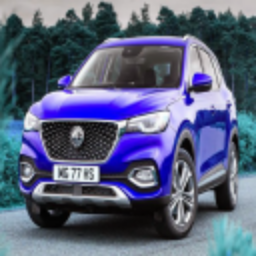

LR


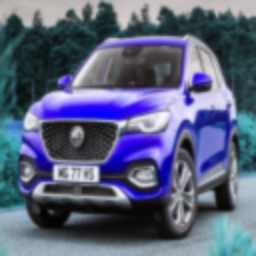

In [ ]:
from skimage import measure

# Load the model
modelPath = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/Model/Model.h5"
model = load_model(modelPath)

# Load and preprocess input images
dataset_name = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/"
hr_folder_name = "high_res"
lr_folder_name = "low_res"
data_loader = DataLoader(dataset_name=dataset_name, hr_name=hr_folder_name, lr_name=lr_folder_name, img_res=(450, 450))
y = data_loader.load_data(1)

# Perform prediction
x = model.predict(y[1])

# Resize the images back to (256, 256) for visualization
y1 = cv2.resize(y[0][0] * 255, (256, 256))
y2 = cv2.resize(y[1][0] * 255, (256, 256))

# Save the images
output_folder = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/GeneratedImages/"
cv2.imwrite(output_folder + "HR_image.png", y1)
cv2.imwrite(output_folder + "LR_image.png", y2)


# Display the images
print("HR")
cv2_imshow(y1)
print("LR")
cv2_imshow(y2)
print("PSNR -> high : generated  ==>",PSNR(y1,y[1]))
print("MSE -> high : generated  ==>",mse(y[0][0],x[0]))


In [ ]:
# from skimage import measure
# modelPath = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/Model/Model(Copy3).h5"
# # modelPath = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/Model/Model.h5"
# dataset_name = "/content/drive/MyDrive/SEM-6-MINI-PROJECT-GAN/DATASET/LrTestData/"
# hr_folder_name = "high_res"
# lr_folder_name = "low_res"
# y = DataLoader(dataset_name=dataset_name,hr_name=hr_folder_name,lr_name=lr_folder_name,img_res=(128,128)).load_data(1)
# # print(y)
# print(y[0].shape)
# print("HR")
# y1 = y[0][0]*255
# y1 = cv2.resize(y1,(256,256))
# cv2_imshow(y1)
# print("LR")
# y2 = y[1][0]*255
# y2 = cv2.resize(y2,(256,256))
# cv2_imshow(y2)
# model = load_model(modelPath)

# x = model.predict(y[1])
# x1 = x[0]*255
# x1 = cv2.resize(x1,(256,256))
# cv2_imshow(x1)



In [ ]:
# from skimage import metrics
# # x[0].shape
# metrics.structural_similarity(y[0][0],x[0])
# model.compile(loss='binary_crossentropy',
#             optimizer=Adam(0.0001, 0.9),
#             metrics=['accuracy'])
# print("MSE -> high : low  ==>",mse(y[0][0],y[1][0]), measure.compare_ssim(y[0][0],y[1][0]))
# print("MSE -> high : generated  ==>",mse(y[0][0],x[0]), measure.compare_ssim(y[0][0],x[0]))
# titles = ['Generated', 'Original']
# fig, axs = plt.subplots(2,2)
# cnt = 0
# for row in range(2):
#     for col, image in enumerate([x, y]):
#         axs[row, col].imshow(image[row])
#         axs[row, col].set_title(titles[col])
#         axs[row, col].axis('off')
#     cnt += 1
# fig.savefig("/content/xxxxxx.png")
# plt.imshow(fig)